In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict

plt.rcParams.update({
    "figure.dpi": 600,
    "figure.figsize": (6, 2.5),
    "font.size": 8,
    "mathtext.fontset": "stix"
})

In [2]:
# --- Analytical calculation ---

def calculate_analytical_Vm(params, freqs):
    """Calculate the analytical transfer function amplitude."""
    Rm = params['Rm']
    Ri = params['Ri']
    Cm = params['Cm']
    d = params['d']
    ds = params['ds']
    l1 = params['l1']
    l2 = params['l2']
    s_in = params['s_in']

    omega = 2 * np.pi * freqs
    omega[0] += 1e-9

    tau_m = Rm * Cm
    lambda_ = np.sqrt((d * Rm) / (4 * Ri))
    L1 = l1 / lambda_
    L2 = l2 / lambda_
    W = omega * tau_m
    q = np.sqrt(1 + 1j * W)

    Ys = np.pi * ds**2 * (1/Rm) * q**2
    G_inf = np.pi * d**2 / (4 * Ri * lambda_)
    Y_inf = q * G_inf
    Y_in_total = Ys + Y_inf * (np.tanh(q * L1) + np.tanh(q * L2))

    numerator = lambda_ * G_inf * (1/np.cosh(q * L2) - 1/np.cosh(q * L1))
    T_p = numerator / Y_in_total

    return 1e3 * np.abs(T_p)  # mV


standard_neuron_parameters = {
    'Rm': 3.0,
    'Ri': 1.5,
    'Cm': 0.01,
    'd': 2e-6,
    'ds': 20e-6,
    'l1': 670e-6,
    'l2': 330e-6,
    's_in': (1e-15)**2
}

frequencies = np.logspace(0, 3.4, 1000)


def generate_V_m_matrix(l_fixed, params, freqs):
    if l_fixed == l_fixed_long:
        l_vary = np.linspace(740e-6, 1345e-6, 50)
    else:
        l_vary = np.linspace(40e-6, 325e-6, 50)

    V_m_matrix = np.zeros((len(l_vary), len(freqs)))

    test_params = params.copy()
    test_params['l2'] = l_fixed

    for i, lv in enumerate(l_vary):
        test_params['l1'] = lv
        V_m_matrix[i] = calculate_analytical_Vm(test_params, freqs)

    return V_m_matrix, l_vary


# --- Compute analytical matrices ---
l_fixed_long  = 0.3e-3
l_fixed_short = 0.12e-3

V_m_matrix_long,  l_vary_long  = generate_V_m_matrix(l_fixed_long,  standard_neuron_parameters, frequencies)
V_m_matrix_short, l_vary_short = generate_V_m_matrix(l_fixed_short, standard_neuron_parameters, frequencies)

delta_l_long_ana  = abs(l_vary_long  - l_fixed_long)  * 1e6
delta_l_short_ana = abs(l_vary_short - l_fixed_short) * 1e6

tot_l_long_ana  = (l_vary_long  + l_fixed_long)  * 1e6
tot_l_short_ana = (l_vary_short + l_fixed_short) * 1e6

In [3]:
# --- Simulation data ---

# --- Load vmem simulation data ---
base_dir = '/Users/susannedahle/CellTypeDependenceElStim/simulation_data/vmem_data_neo' 

vmem_amp_file_paths = [
    os.path.join(base_dir, f'vmem_amp_data_neo_Ez_{i}.npy')
    for i in range(16)
]

vmem_amp_data_list = [
    np.load(path, allow_pickle=True).item()
    for path in vmem_amp_file_paths
]
vmem_amp_data = {}
for data in vmem_amp_data_list:
    vmem_amp_data.update(data)

# --- Separate out short and long cells ---

l1_short_limit = 220
l2_short_limit = 290
l1_long_limit = 750
l2_long_limit = 200

short_cells = []
long_cells = []

for cell_name, data in vmem_amp_data.items():
    l1 = data['upper_z_endpoint']
    l2 = abs(data['bottom_z_endpoint'])
    if l1 <= l1_short_limit and l2 <= l2_short_limit:
        if abs(l1 - l2) < 175:
            short_cells.append(cell_name)
    if l1 >= l1_long_limit and l2 >= l2_long_limit:
        long_cells.append(cell_name)

tot_long_lengths = []
for cell_name in long_cells:
    tot_long_lengths.append(vmem_amp_data[cell_name]['total_len']) 
tot_short_lengths = []
for cell_name in short_cells:
    tot_short_lengths.append(vmem_amp_data[cell_name]['total_len']) 

# --- Extract l1 values for each group ---
l1_for_long_cells  = np.sort([vmem_amp_data[c]['upper_z_endpoint'] for c in long_cells])
l1_for_short_cells = np.sort([vmem_amp_data[c]['upper_z_endpoint'] for c in short_cells])

# --- Compute Δl for every cell ---
delta_l = {
    name: abs(data["upper_z_endpoint"] - abs(data["bottom_z_endpoint"]))
    for name, data in vmem_amp_data.items()
}

def average_by_delta_l(cell_list):
    """
    Groups cells by identical Δl and averages soma_amp across those cells.
    Returns:
        delta_l_unique  : sorted unique Δl values
        averaged_matrix : matrix (#unique Δl, #freqs)
    """
    # temporary storage: Δl → list of Vm curves
    groups = defaultdict(list)

    for name in cell_list:
        dl = delta_l[name]
        groups[dl].append(vmem_amp_data[name]['soma_amp'])

    # sort Δl values
    delta_l_unique = np.array(sorted(groups.keys()))

    # average curves for each Δl group
    averaged_matrix = np.array([
        np.mean(groups[dl], axis=0)
        for dl in delta_l_unique
    ])

    return delta_l_unique, averaged_matrix

# --- Build Vm matrices with averaging if several cells have the same Δl ---

delta_l_long,  long_matrix  = average_by_delta_l(long_cells)
delta_l_short, short_matrix = average_by_delta_l(short_cells)

# --- Frequencies for simulation data ---
frequencies_sim = vmem_amp_data['L1_DAC_bNAC219_1']['freq']

print('--- Long neuron values ---')
print(f'Long tot lengths: {np.min(tot_long_lengths)} µm, to {np.max(tot_long_lengths)} µm')
print(f'Long delta l values: {np.min(delta_l_long)} µm, to {np.max(delta_l_long)} µm')
print('--- Short neuron values ---')
print(f'Short tot lengths: {np.min(tot_short_lengths)} µm, to {np.max(tot_short_lengths)} µm')
print(f'Short delta l values: {np.min(delta_l_short)} µm, to {np.max(delta_l_short)} µm')

--- Long neuron values ---
Long tot lengths: 1019.3204057943343 µm, to 1662.2022847194041 µm
Long delta l values: 459.0417879720992 µm, to 1026.3426621859562 µm
--- Short neuron values ---
Short tot lengths: 80.09459008857266 µm, to 480.98147000766795 µm
Short delta l values: 0.036897641372860335 µm, to 165.39617199591578 µm


In [4]:
print('--- Long neuron values ---')
print(f'Long tot lengths: {np.min(tot_l_long_ana)} µm, to {np.max(tot_l_long_ana)} µm')
print(f'Long delta l values: {np.min(delta_l_long_ana)} µm, to {np.max(delta_l_long_ana)} µm')
print('--- Short neuron values ---')
print(f'Short tot lengths: {np.min(tot_l_short_ana)} µm, to {np.max(tot_l_short_ana)} µm')
print(f'Short delta l values: {np.min(delta_l_short_ana)} µm, to {np.max(delta_l_short_ana)} µm')

--- Long neuron values ---
Long tot lengths: 1040.0 µm, to 1645.0 µm
Long delta l values: 440.0 µm, to 1045.0000000000002 µm
--- Short neuron values ---
Short tot lengths: 160.0 µm, to 445.0 µm
Short delta l values: 1.4285714285714266 µm, to 205.0 µm


<>:17: SyntaxWarning: invalid escape sequence '\h'
<>:27: SyntaxWarning: invalid escape sequence '\h'
<>:17: SyntaxWarning: invalid escape sequence '\h'
<>:27: SyntaxWarning: invalid escape sequence '\h'
/var/folders/bg/0phzw_wj05x5crg_p858d9b80000gn/T/ipykernel_23670/3849869406.py:17: SyntaxWarning: invalid escape sequence '\h'
  fig.colorbar(pcm, ax=axes[0, 0], label='$|\hat{\mathbf{V}}_\mathrm{m}|$ Analytical [mV]')
/var/folders/bg/0phzw_wj05x5crg_p858d9b80000gn/T/ipykernel_23670/3849869406.py:27: SyntaxWarning: invalid escape sequence '\h'
  fig.colorbar(pcm, ax=axes[0, 1], label='$|\hat{\mathbf{V}}_\mathrm{m}|$ Analytical [mV]')
/var/folders/bg/0phzw_wj05x5crg_p858d9b80000gn/T/ipykernel_23670/3849869406.py:20: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm = axes[0, 1].pcolor

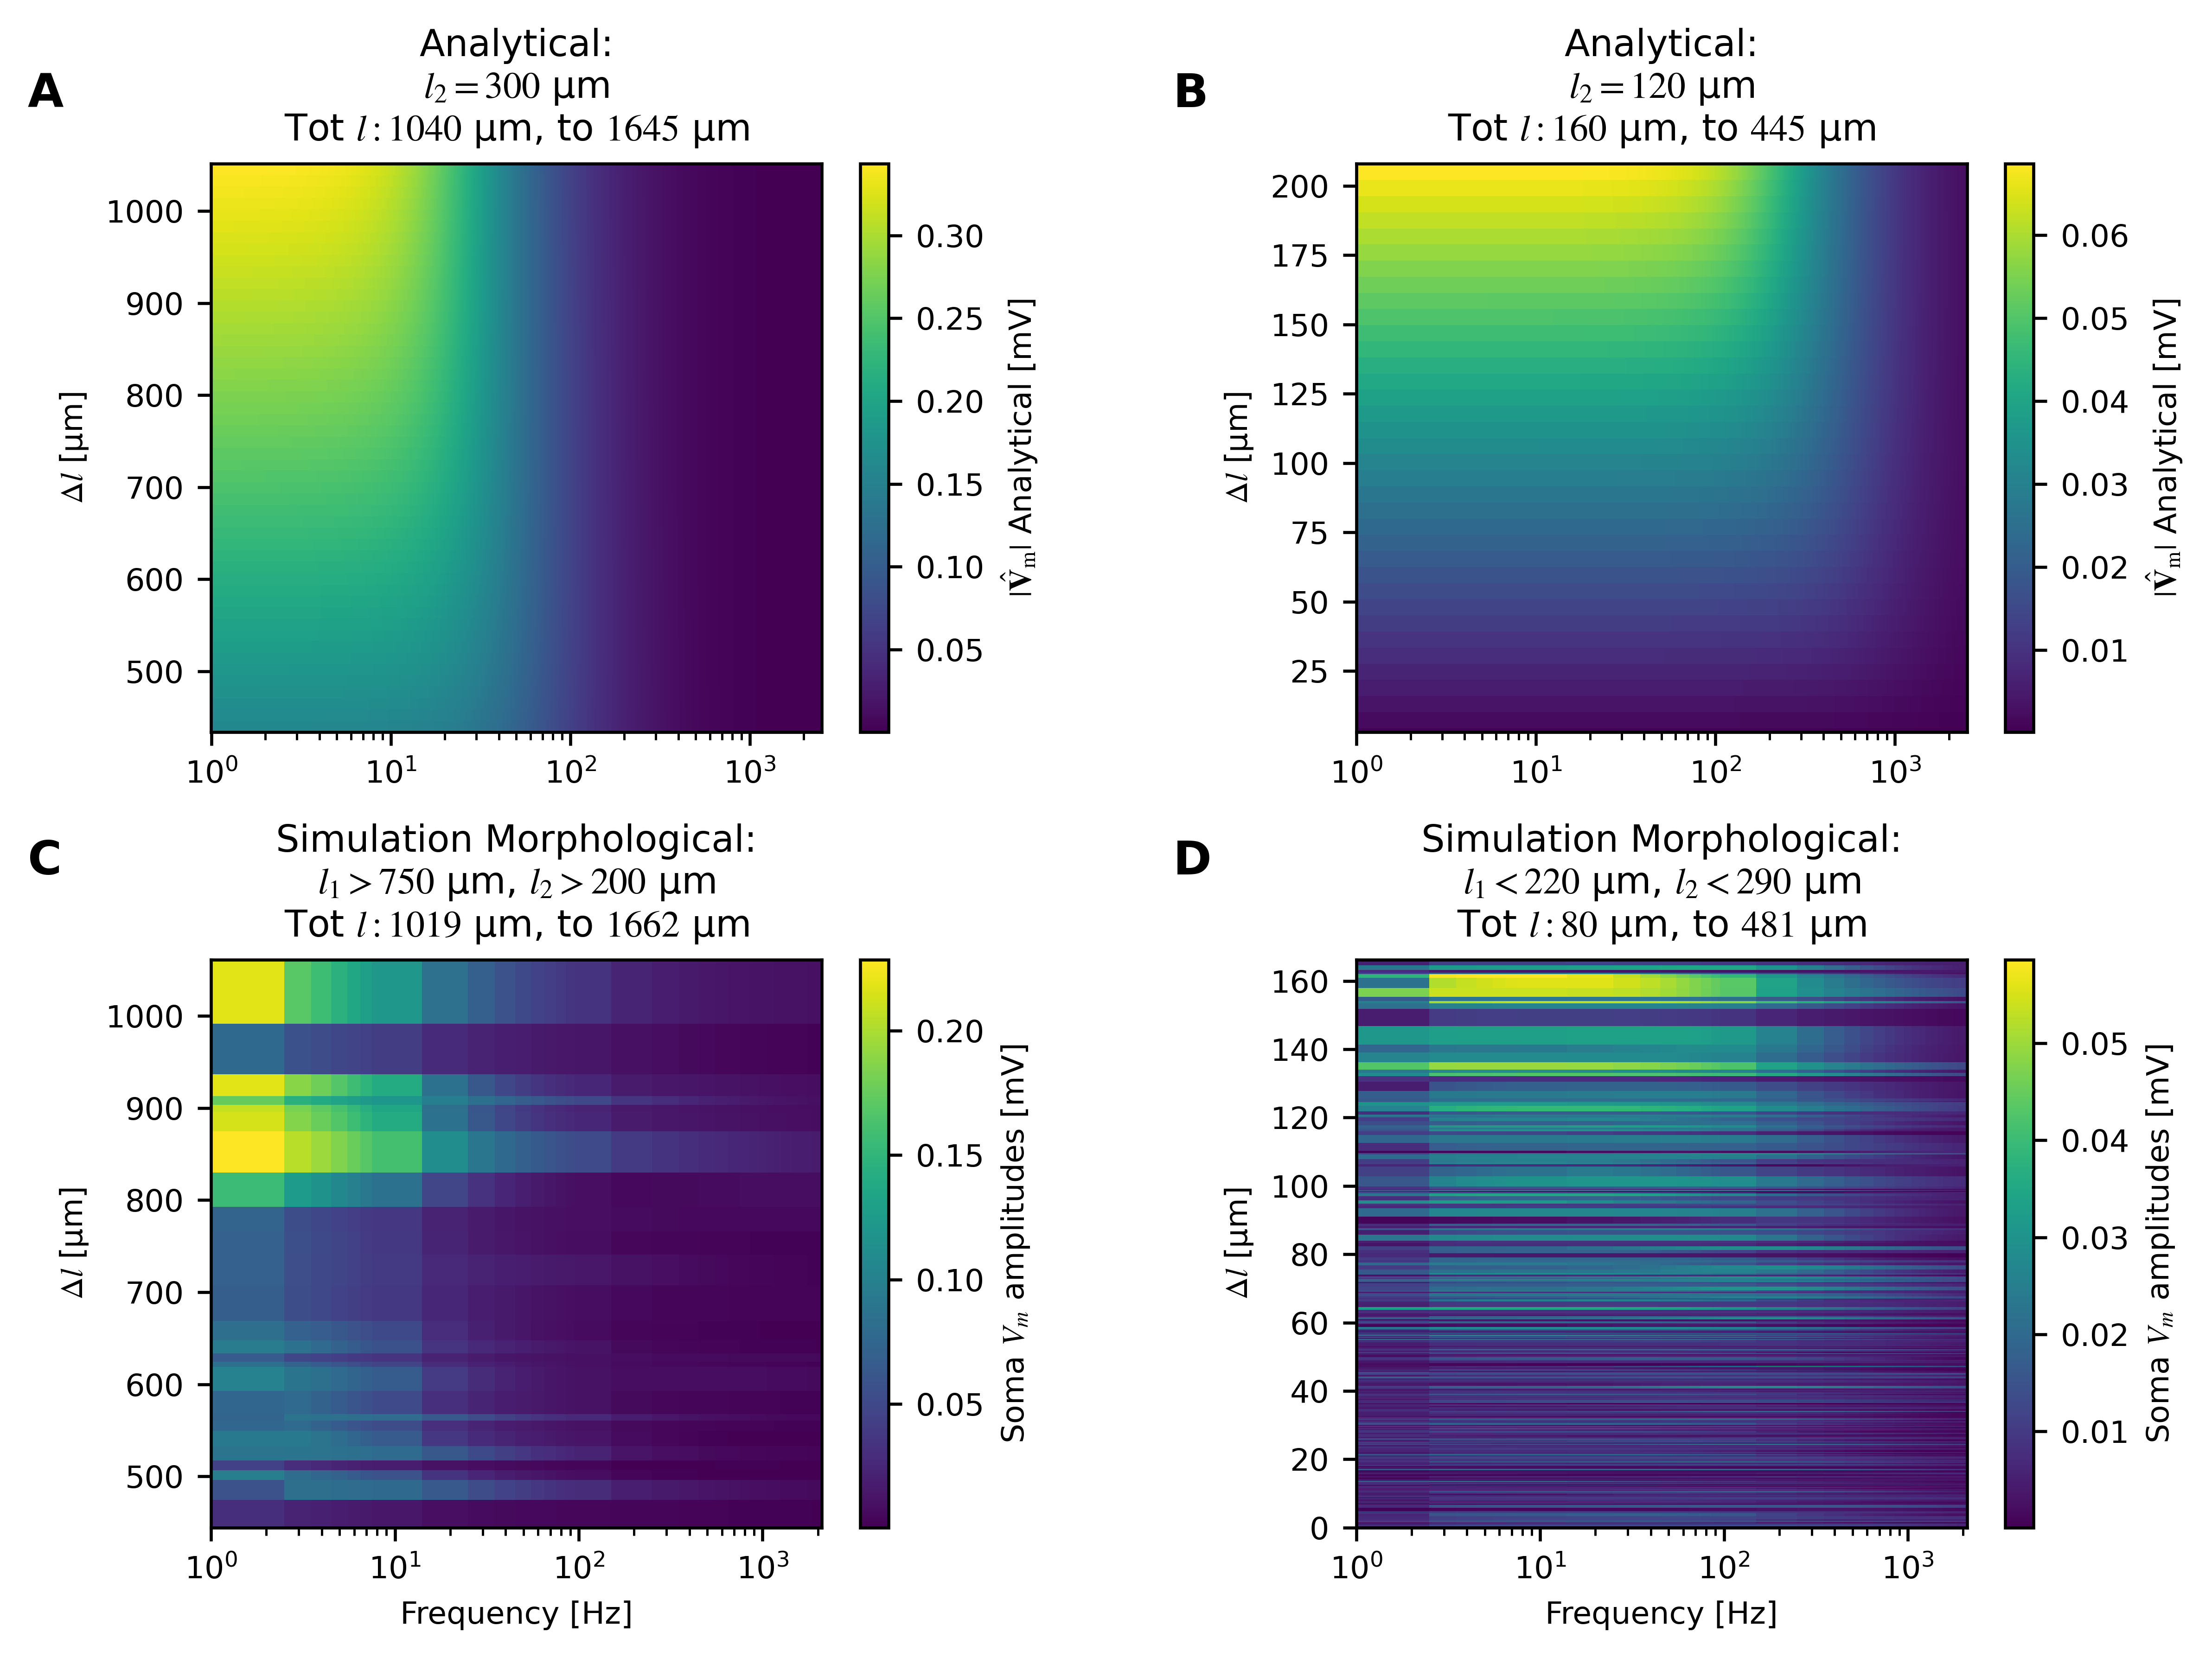

In [6]:
# --- Plotting ---

fig, axes = plt.subplots(2, 2, figsize=(8, 6))

# ---------------------------------------------------------
#  Row 1 — ANALYTICAL
# ---------------------------------------------------------

# --- Analytical Long ---
pcm = axes[0, 0].pcolormesh(
    frequencies, delta_l_long_ana, V_m_matrix_long,
    shading='nearest', cmap='viridis', rasterized=True
)
axes[0, 0].set_xscale('log')
axes[0, 0].set_title(f"Analytical:\n$l_2 = {l_fixed_long*1e6:.0f}$ µm\nTot $l: {np.min(tot_l_long_ana):.0f}$ µm, to ${np.max(tot_l_long_ana):.0f}$ µm")
axes[0, 0].set_ylabel(r'$\Delta l$ [µm]')
fig.colorbar(pcm, ax=axes[0, 0], label='$|\hat{\mathbf{V}}_\mathrm{m}|$ Analytical [mV]')

# --- Analytical Short ---
pcm = axes[0, 1].pcolormesh(
    frequencies, delta_l_short_ana, V_m_matrix_short,
    shading='nearest', cmap='viridis', rasterized=True
)
axes[0, 1].set_xscale('log')
axes[0, 1].set_title(f"Analytical:\n$l_2 = {l_fixed_short*1e6:.0f}$ µm\nTot $l: {np.min(tot_l_short_ana):.0f}$ µm, to ${np.max(tot_l_short_ana):.0f}$ µm")
axes[0, 1].set_ylabel(r'$\Delta l$ [µm]')
fig.colorbar(pcm, ax=axes[0, 1], label='$|\hat{\mathbf{V}}_\mathrm{m}|$ Analytical [mV]')


# ---------------------------------------------------------
#  Row 2 — SIMULATION
# ---------------------------------------------------------

# --- Simulation Long ---
pcm = axes[1, 0].pcolormesh(
    frequencies_sim, delta_l_long, long_matrix,
    shading='nearest', cmap='viridis', rasterized=True
)
axes[1, 0].set_xscale('log')
axes[1, 0].set_title(f"Simulation Morphological:\n$l_1 > {l1_long_limit}$ µm, $l_2 > {l2_long_limit}$ µm\nTot $l: {np.min(tot_long_lengths):.0f}$ µm, to ${np.max(tot_long_lengths):.0f}$ µm")
axes[1, 0].set_xlabel("Frequency [Hz]")
axes[1, 0].set_ylabel(r'$\Delta l$ [µm]')
axes[1, 0].set_xlim(left = 1, right = 2100)
fig.colorbar(pcm, ax=axes[1, 0], label='Soma $V_m$ amplitudes [mV]')

# --- Simulation Short ---
pcm = axes[1, 1].pcolormesh(
    frequencies_sim, delta_l_short, short_matrix,
    shading='nearest', cmap='viridis', rasterized=True
)
axes[1, 1].set_xscale('log')
axes[1, 1].set_title(f"Simulation Morphological:\n$l_1 < {l1_short_limit}$ µm, $l_2 < {l2_short_limit}$ µm\nTot $l: {np.min(tot_short_lengths):.0f}$ µm, to ${np.max(tot_short_lengths):.0f}$ µm")
axes[1, 1].set_xlabel("Frequency [Hz]")
axes[1, 1].set_ylabel(r'$\Delta l$ [µm]')
axes[1, 1].set_xlim(left = 1, right = 2100)
fig.colorbar(pcm, ax=axes[1, 1], label='Soma $V_m$ amplitudes [mV]')

axes[0,0].text(-0.3, 1.10, 'A', transform=axes[0,0].transAxes, fontsize=12, fontweight='bold')
axes[0,1].text(-0.3, 1.10, 'B', transform=axes[0,1].transAxes, fontsize=12, fontweight='bold')
axes[1,0].text(-0.3, 1.15, 'C', transform=axes[1,0].transAxes, fontsize=12, fontweight='bold')
axes[1,1].text(-0.3, 1.15, 'D', transform=axes[1,1].transAxes, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.subplots_adjust(wspace=0.5, hspace= 0.4)
plt.savefig('/Users/susannedahle/Documents/Master/Code/fig_pdfs/fig11.pdf',
    bbox_inches='tight', transparent=False,)
plt.show()